# Install Libraries if Needed (Only Run Once)

In [1]:
# !pip install -U deepxde

# Import Libraries

In [2]:
# Interactive Plotting

# for jupyter notebooks
%matplotlib notebook 

# for jupyter labs
# %matplotlib widget 

In [3]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import io
import re
import os

import matplotlib.pyplot as plt
import numpy as np

import deepxde as dde
from deepxde.backend import tf

from mpl_toolkits.mplot3d import Axes3D
import sys
from scipy.integrate import odeint
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

Using backend: tensorflow.compat.v1



Instructions for updating:
non-resource variables are not supported in the long term



# Burgers Equation

$$
u_t + u u_x = \frac{0.01}{\pi} u_{xx}, \\
x \in (-1, 1), t \in (0, 0.99],\\
u(x,0) = -\sin(\pi x), \\
u(-1,t) = u(1,t) = 0
$$

# Define Generate Test Data Function

In [4]:
def gen_testdata():
    data = np.load("dataset/Burgers.npz")
    t, x, exact = data["t"], data["x"], data["usol"].T
    xx, tt = np.meshgrid(x, t)
    X = np.vstack((np.ravel(xx), np.ravel(tt))).T
    y = exact.flatten()[:, None]
    Nx = len(x)
    Nt = len(t)
    return X, y, Nx, Nt

# Define PDE

In [8]:
def pde(x, y):
    dy_x = dde.grad.jacobian(y, x, i=0, j=0)
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    return dy_t + y * dy_x - 0.01 / np.pi * dy_xx

# Define Geometry

In [5]:
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 0.99)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)


# Define ICs/BCs

In [6]:
bc = dde.DirichletBC(geomtime, # geometry
                     lambda x: 0, # value of specified boundary
                     lambda _, on_boundary: on_boundary # check if point is on specified boundary (function of coordinates and boolean on_boundary returns boolean)
                    )
ic = dde.IC(geomtime, # geometry
            lambda x: -np.sin(np.pi * x[:, 0:1]), # value of initial condition
            lambda _, on_initial: on_initial # check if point is an initial condition (function of coordinates and boolean on_initial returns boolean)
           )

# Construct Data (geometry + PDE + ICs/BCs)

In [9]:
data = dde.data.TimePDE(geomtime, # geometry
                        pde, # pde
                        [bc, ic], # ICs/BCs
                        num_domain=2540, # number of points in domain
                        num_boundary=80, # number of points on boundary
                        num_initial=160 # number of points on initial 
                       )

/home/shawngr/.conda/envs/env/lib/python3.8/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+2542=2542. 
  warnings.warn("The balance properties of Sobol' points require "
/home/shawngr/.conda/envs/env/lib/python3.8/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+82=82. 
  warnings.warn("The balance properties of Sobol' points require "
/home/shawngr/.conda/envs/env/lib/python3.8/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+162=162. 
  warnings.warn("The balance properties of Sobol' points require "


# Define Network Architecture

In [10]:
net = dde.maps.FNN([2] + [20] * 3 + [1], # layers
                   "tanh", # activation function
                   "Glorot normal" # initializer
                  )

# Define Model (data + net)

In [11]:
model = dde.Model(data, net)

# Define Paths

In [28]:
save_dir = 'Burgers'
model_name = 'model'
os.makedirs(save_dir, exist_ok=True)
model_path = os.path.join(save_dir, model_name)
ckpt_path = tf.train.latest_checkpoint(save_dir)
loss_fname = 'loss_Burgers.dat'
train_fname = 'train_Burgers.dat'
test_fname = 'test_Burgers.dat'
loss_path = os.path.join(save_dir, loss_fname)
train_path = os.path.join(save_dir, train_fname)
test_path = os.path.join(save_dir, test_fname)

# ckpt_path = os.path.join(save_dir, 'checkpoint')
# model.save(model_path)

# Load Model

In [29]:
model.compile("adam", lr=1e-3)
model.restore(ckpt_path, verbose=1)

Compiling model...
'compile' took 0.208043 s

Restoring model from Burgers/model-20037.ckpt ...

INFO:tensorflow:Restoring parameters from Burgers/model-20037.ckpt


# Train the Model
Here we train the model twice.  Once with Adam optimizer for initial training.  Then again with L-BFGS-B optimizer for finetuning.

In [13]:
model.compile("adam", lr=1e-3)
model.train(epochs=20000)
model.compile("L-BFGS-B")
losshistory, train_state = model.train()

Compiling model...
Building feed-forward neural network...
'build' took 0.088497 s



/home/shawngr/.conda/envs/env/lib/python3.8/site-packages/keras/legacy_tf_layers/core.py:236: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/home/shawngr/.conda/envs/env/lib/python3.8/site-packages/keras/engine/base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


'compile' took 12.204713 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric
0         [2.01e-02, 2.60e-03, 4.74e-01]    [2.01e-02, 2.60e-03, 4.74e-01]    []  
1000      [4.12e-02, 7.46e-04, 5.86e-02]    [4.12e-02, 7.46e-04, 5.86e-02]    []  
2000      [3.46e-02, 2.91e-04, 4.63e-02]    [3.46e-02, 2.91e-04, 4.63e-02]    []  
3000      [2.80e-02, 1.10e-04, 3.98e-02]    [2.80e-02, 1.10e-04, 3.98e-02]    []  
4000      [1.65e-02, 5.65e-05, 1.84e-02]    [1.65e-02, 5.65e-05, 1.84e-02]    []  
5000      [8.29e-03, 5.60e-05, 1.12e-02]    [8.29e-03, 5.60e-05, 1.12e-02]    []  
6000      [5.04e-03, 5.43e-05, 3.73e-03]    [5.04e-03, 5.43e-05, 3.73e-03]    []  
7000      [3.84e-03, 1.01e-05, 3.07e-03]    [3.84e-03, 1.01e-05, 3.07e-03]    []  
8000      [3.43e-03, 2.95e-05, 2.50e-03]    [3.43e-03, 2.95e-05, 2.50e-03]    []  
9000      [2.81e-03, 1.20e-05, 2.37e-03]    [2.81e-03, 1.20e-05, 2.37e-03]    []  
10000  

# Save Model

In [26]:
model.save(model_path)

INFO:tensorflow:Burgers/model-20037.ckpt is not in all_model_checkpoint_paths. Manually adding it.


'Burgers/model-20037.ckpt'

# Plot Training Performance

Saving loss history to /gpfs/mira-home/shawngr/ai-science-training-series/07_physics-inspiredAI/Burgers/loss_Burgers.dat ...
Saving training data to /gpfs/mira-home/shawngr/ai-science-training-series/07_physics-inspiredAI/Burgers/train_Burgers.dat ...
Saving test data to /gpfs/mira-home/shawngr/ai-science-training-series/07_physics-inspiredAI/Burgers/test_Burgers.dat ...


<IPython.core.display.Javascript object>


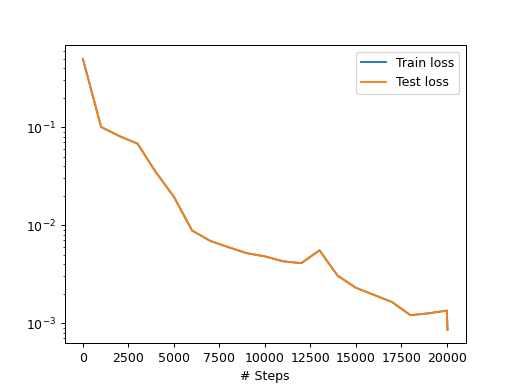

<IPython.core.display.Javascript object>


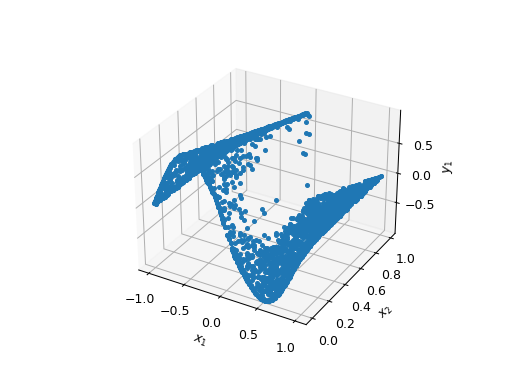

In [15]:
dde.saveplot(losshistory, train_state, issave=True, isplot=True, loss_fname=loss_path, train_fname=train_path, test_fname=test_path)


# Load the Test Data

In [30]:
x_test, y_true, Nx, Nt = gen_testdata()
y_pred = model.predict(x_test)
print("L2 relative error:", dde.metrics.l2_relative_error(y_true, y_pred))
np.savetxt("test_burgers.dat", np.hstack((x_test, y_true, y_pred)))

L2 relative error: 0.2155619983531562


In [31]:
X_test, T_test = x_test[:,0], x_test[:,1]
X = X_test.reshape((Nt, Nx))
T = T_test.reshape((Nt, Nx))
Y_pred = y_pred.reshape((Nt, Nx))
Y_test = y_true.reshape((Nt, Nx))
x = X[0]
t = T[:,0]

<IPython.core.display.Javascript object>


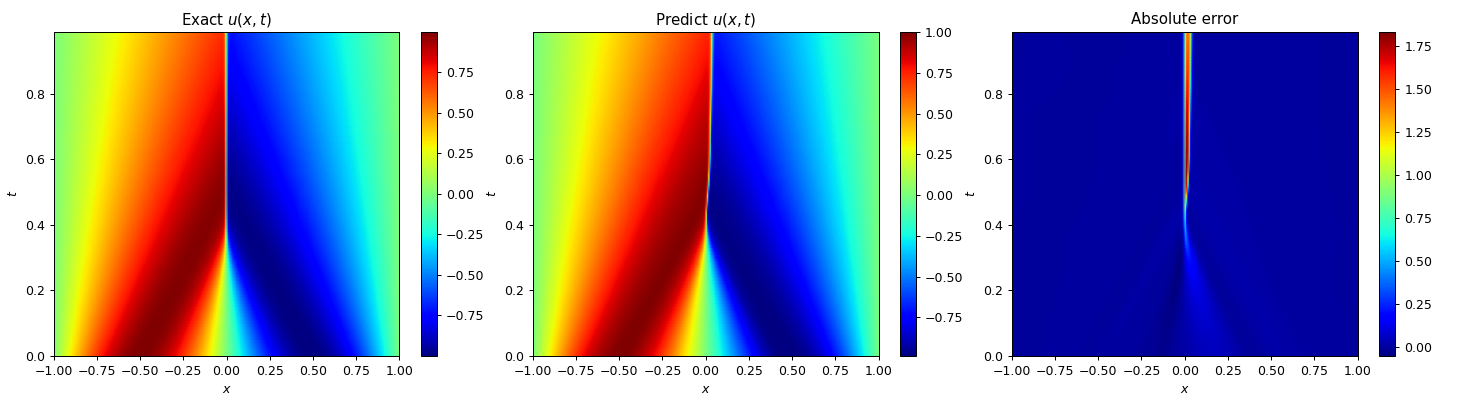

In [32]:
fig = plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
# plt.pcolor(XX,TT, S_test, cmap='jet')
plt.pcolormesh(X, T, Y_test, cmap='jet', shading='gouraud')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title('Exact $u(x,t)$')
plt.tight_layout()

plt.subplot(1,3,2)
# plt.pcolor(XX,TT, S_pred, cmap='jet')
plt.pcolormesh(X, T, Y_pred, cmap='jet', shading='gouraud')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title('Predict $u(x,t)$')
plt.tight_layout()

plt.subplot(1,3,3)
# plt.pcolor(XX,TT, S_pred - S_test, cmap='jet')
plt.pcolormesh(X, T, Y_pred - Y_test, cmap='jet', shading='gouraud')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title('Absolute error')
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


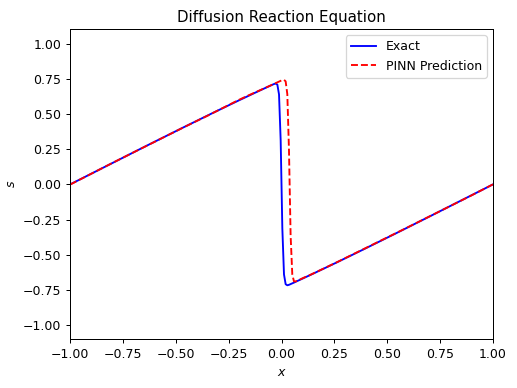

In [33]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()
ax.plot(x, Y_test[0], 'b-', label='Exact')
ax.plot(x, Y_pred[0], 'r--', label='PINN Prediction')
ylim = plt.ylim()
xlim = [-1, 1]
plt.tight_layout()


for i in range(Nt):
    ax.clear()
    ax.plot(x, Y_test[i], 'b-', label='Exact')
    ax.plot(x, Y_pred[i], 'r--', label='PINN Prediction')
    plt.ylim(ylim)
    plt.xlim(xlim)
    plt.xlabel(f'$x$')
    plt.ylabel(f'$s$')
    plt.title(f'Diffusion Reaction Equation')
    plt.legend(loc='upper right')
    plt.tight_layout()
    fig.canvas.draw()

# Optionally Refine by Adding Additional Points Near Potential Shock (True Shock Occurs at Low to Zero Viscosity)

In [34]:
save_dir = 'Burgers_RAR'
model_name = 'model_RAR'
os.makedirs(save_dir, exist_ok=True)
model_path = os.path.join(save_dir, model_name)
ckpt_path = tf.train.latest_checkpoint(save_dir)
loss_fname = 'loss_Burgers_RAR.dat'
train_fname = 'train_Burgers_RAR.dat'
test_fname = 'test_Burgers_RAR.dat'
loss_path = os.path.join(save_dir, loss_fname)
train_path = os.path.join(save_dir, train_fname)
test_path = os.path.join(save_dir, test_fname)

# ckpt_path = os.path.join(save_dir, 'checkpoint')
# model.save(model_path)

In [35]:
model.compile("adam", lr=1e-3)
model.restore(ckpt_path)

Compiling model...
'compile' took 0.217309 s

INFO:tensorflow:Restoring parameters from Burgers_RAR/model_RAR-64080.ckpt


In [14]:
X_reample = geomtime.random_points(100000)
err = 1
while err > 0.01:
    f = model.predict(X_reample, operator=pde)
    err_eq = np.absolute(f)
    err = np.mean(err_eq)
    print("Mean residual: %.3e" % (err))

    x_id = np.argmax(err_eq)
    print("Adding new point:", X_reample[x_id], "\n")
    data.add_anchors(X_reample[x_id])
    early_stopping = dde.callbacks.EarlyStopping(min_delta=1e-4, patience=2000)
    model.compile("adam", lr=1e-3)
    model.train(
        epochs=10000, disregard_previous_best=True, callbacks=[early_stopping]
    )
    model.compile("L-BFGS-B")
    losshistory, train_state = model.train()

Mean residual: 4.163e-02
Adding new point: [0.01024818 0.48011178] 

Compiling model...
'compile' took 0.202018 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric
0         [1.77e-02, 2.36e-02, 4.08e-01]    [1.77e-02, 2.36e-02, 4.08e-01]    []  
1000      [3.48e-02, 2.05e-04, 5.08e-02]    [3.48e-02, 2.05e-04, 5.08e-02]    []  
2000      [2.67e-02, 2.43e-05, 3.68e-02]    [2.67e-02, 2.43e-05, 3.68e-02]    []  
3000      [1.25e-02, 6.73e-05, 1.03e-02]    [1.19e-02, 6.73e-05, 1.03e-02]    []  
4000      [5.04e-03, 1.66e-05, 2.86e-03]    [4.92e-03, 1.66e-05, 2.86e-03]    []  
5000      [3.53e-03, 2.24e-05, 1.74e-03]    [3.44e-03, 2.24e-05, 1.74e-03]    []  
6000      [2.49e-03, 1.63e-05, 1.21e-03]    [2.44e-03, 1.63e-05, 1.21e-03]    []  
7000      [2.27e-03, 1.21e-05, 9.47e-04]    [2.24e-03, 1.21e-05, 9.47e-04]    []  
8000      [1.86e-03, 1.70e-05, 8.09e-04]    [1.83e-03, 1.70e-05, 8.09e-04]    []  
900

31000     [1.02e-03, 6.33e-06, 4.29e-04]    [7.52e-04, 6.33e-06, 4.29e-04]    []  
Epoch 31000: early stopping

Best model at step 29000:
  train loss: 9.14e-04
  test loss: 8.75e-04
  test metric: []

'train' took 7.797254 s

Compiling model...
'compile' took 0.168083 s

Training model...

Step      Train loss                        Test loss                         Test metric
31000     [1.02e-03, 6.33e-06, 4.29e-04]    [7.52e-04, 6.33e-06, 4.29e-04]    []  
INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  Objective function value: 0.000767
  Number of iterations: 8
  Number of functions evaluations: 62
31062     [3.93e-04, 7.21e-07, 3.73e-04]    [3.87e-04, 7.21e-07, 3.73e-04]    []  

Best model at step 31062:
  train loss: 7.67e-04
  test loss: 7.60e-04
  test metric: []

'train' took 0.961572 s

Mean residual: 1.585e-02
Adding new point: [0.00618076 0.4534346 ] 

Compiling model...
'compile' took 0.238456 s

Training model.

51000     [4.72e-04, 3.51e-06, 2.02e-04]    [3.29e-04, 3.51e-06, 2.02e-04]    []  
Epoch 51000: early stopping

Best model at step 50000:
  train loss: 5.49e-04
  test loss: 5.09e-04
  test metric: []

'train' took 8.394639 s

Compiling model...
'compile' took 0.205628 s

Training model...

Step      Train loss                        Test loss                         Test metric
51000     [4.72e-04, 3.51e-06, 2.02e-04]    [3.29e-04, 3.51e-06, 2.02e-04]    []  
INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  Objective function value: 0.000464
  Number of iterations: 6
  Number of functions evaluations: 30
51030     [2.85e-04, 1.80e-06, 1.77e-04]    [2.72e-04, 1.80e-06, 1.77e-04]    []  

Best model at step 51030:
  train loss: 4.64e-04
  test loss: 4.51e-04
  test metric: []

'train' took 1.859055 s

Mean residual: 1.225e-02
Adding new point: [0.019099   0.34947997] 

Compiling model...
'compile' took 0.274264 s

Training model.

In [29]:
model.save(model_path)

INFO:tensorflow:Burgers_RAR/model_RAR-64080.ckpt is not in all_model_checkpoint_paths. Manually adding it.


'Burgers_RAR/model_RAR-64080.ckpt'

Saving loss history to /gpfs/mira-home/shawngr/ai-science-training-series/07_physics-inspiredAI/Burgers_RAR/loss_Burgers_RAR.dat ...
Saving training data to /gpfs/mira-home/shawngr/ai-science-training-series/07_physics-inspiredAI/Burgers_RAR/train_Burgers_RAR.dat ...
Saving test data to /gpfs/mira-home/shawngr/ai-science-training-series/07_physics-inspiredAI/Burgers_RAR/test_Burgers_RAR.dat ...


<IPython.core.display.Javascript object>


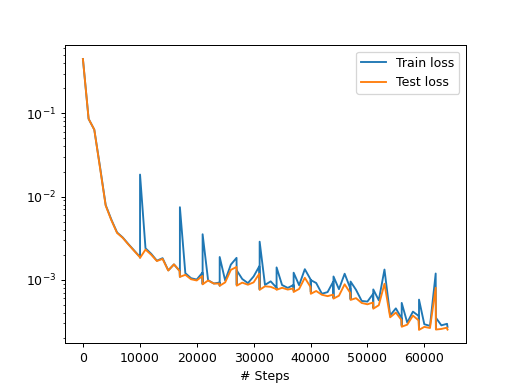

<IPython.core.display.Javascript object>


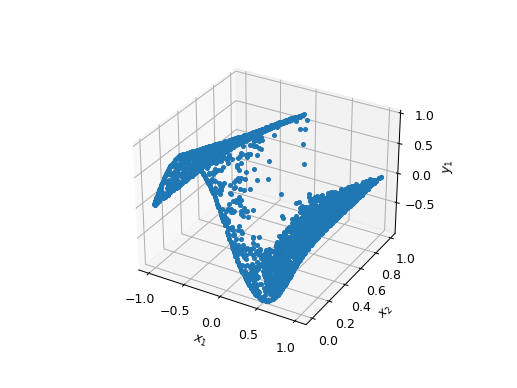

In [16]:
dde.saveplot(losshistory, train_state, issave=True, isplot=True, loss_fname=loss_path, train_fname=train_path, test_fname=test_path)


# Load the Test Data

In [36]:
x_test, y_true, Nx, Nt = gen_testdata()
y_pred = model.predict(x_test)
print("L2 relative error:", dde.metrics.l2_relative_error(y_true, y_pred))
np.savetxt("test_burgers.dat", np.hstack((x_test, y_true, y_pred)))

L2 relative error: 0.01185473455539224


In [37]:
X_test, T_test = x_test[:,0], x_test[:,1]
X = X_test.reshape((Nt, Nx))
T = T_test.reshape((Nt, Nx))
Y_pred = y_pred.reshape((Nt, Nx))
Y_test = y_true.reshape((Nt, Nx))
x = X[0]
t = T[:,0]

<IPython.core.display.Javascript object>


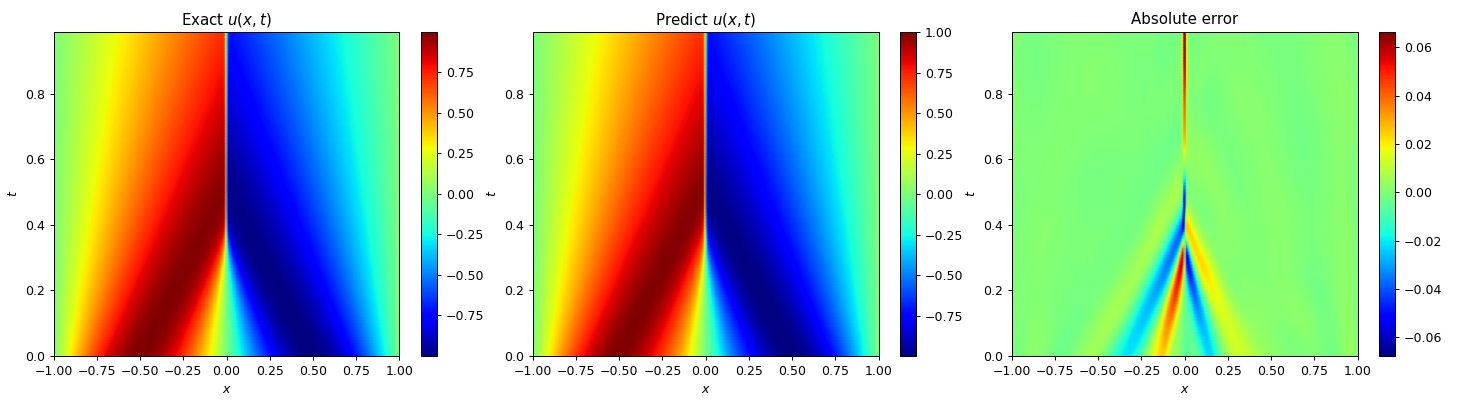

In [38]:
fig = plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
# plt.pcolor(XX,TT, S_test, cmap='jet')
plt.pcolormesh(X, T, Y_test, cmap='jet', shading='gouraud')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title('Exact $u(x,t)$')
plt.tight_layout()

plt.subplot(1,3,2)
# plt.pcolor(XX,TT, S_pred, cmap='jet')
plt.pcolormesh(X, T, Y_pred, cmap='jet', shading='gouraud')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title('Predict $u(x,t)$')
plt.tight_layout()

plt.subplot(1,3,3)
# plt.pcolor(XX,TT, S_pred - S_test, cmap='jet')
plt.pcolormesh(X, T, Y_pred - Y_test, cmap='jet', shading='gouraud')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title('Absolute error')
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


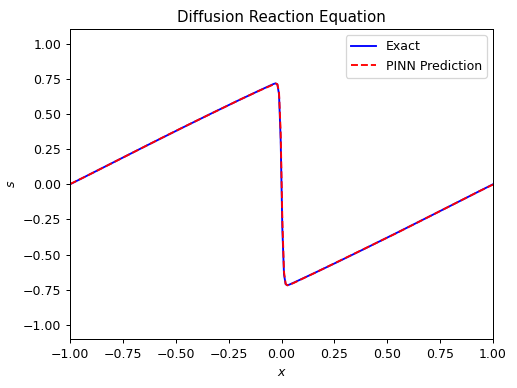

In [39]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()
ax.plot(x, Y_test[0], 'b-', label='Exact')
ax.plot(x, Y_pred[0], 'r--', label='PINN Prediction')
ylim = plt.ylim()
xlim = [-1, 1]
plt.tight_layout()


for i in range(Nt):
    ax.clear()
    ax.plot(x, Y_test[i], 'b-', label='Exact')
    ax.plot(x, Y_pred[i], 'r--', label='PINN Prediction')
    plt.ylim(ylim)
    plt.xlim(xlim)
    plt.xlabel(f'$x$')
    plt.ylabel(f'$s$')
    plt.title(f'Diffusion Reaction Equation')
    plt.legend(loc='upper right')
    plt.tight_layout()
    fig.canvas.draw()